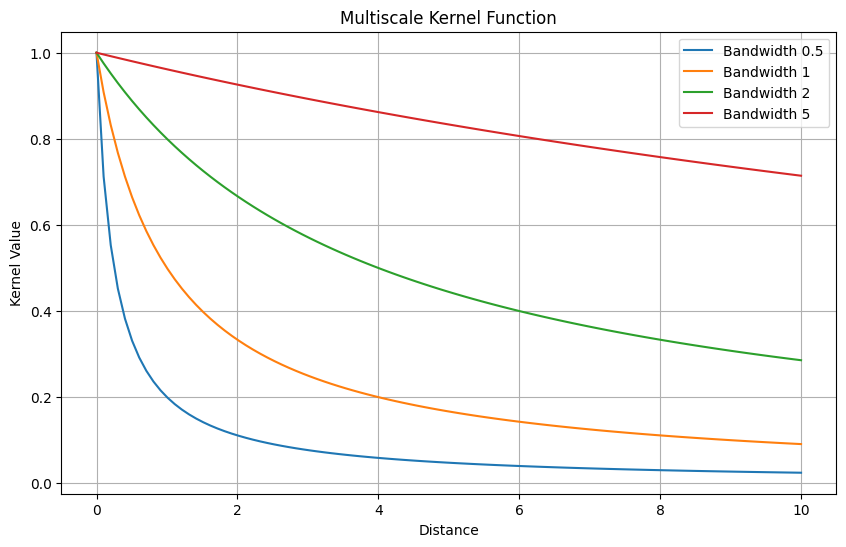

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def multiscale_kernel(distance, bandwidth_range):
    """
    多尺度带宽函数

    Args:
    distance: 样本之间的距离
    bandwidth_range: 不同尺度的带宽参数列表

    Returns:
    values: 不同尺度下的核函数值列表
    """

    values = []
    for a in bandwidth_range:
        value = a**2 / (a**2 + distance)
        values.append(value)

    return values

# 生成距离范围
distance_range = np.linspace(0, 10, 100)

# 定义不同尺度的带宽参数
bandwidth_range = [0.5, 1, 2, 5]

# 计算多尺度带宽函数的值
kernel_values = []
for distance in distance_range:
    values = multiscale_kernel(distance, bandwidth_range)
    kernel_values.append(values)

# 绘制多尺度带宽函数的分布图
plt.figure(figsize=(10, 6))
for i in range(len(bandwidth_range)):
    plt.plot(distance_range, [kernel_values[j][i] for j in range(len(distance_range))], label=f'Bandwidth {bandwidth_range[i]}')
plt.xlabel('Distance')
plt.ylabel('Kernel Value')
plt.title('Multiscale Kernel Function')
plt.legend()
plt.grid(True)
plt.show()

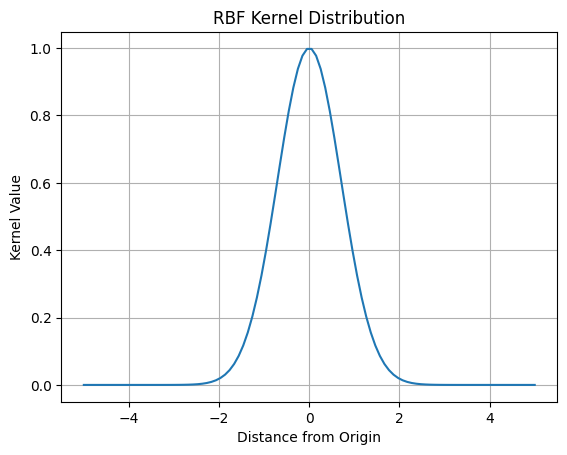

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel(x, y, gamma=1):
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

# 生成一组样本
x = np.linspace(-5, 5, 100)
y = np.zeros_like(x)

# 计算样本之间的 RBF 核函数值
for i, xi in enumerate(x):
    y[i] = rbf_kernel(xi, 0)  # 以原点为中心

# 绘制 RBF 核函数的分布图
plt.plot(x, y)
plt.title('RBF Kernel Distribution')
plt.xlabel('Distance from Origin')
plt.ylabel('Kernel Value')
plt.grid(True)
plt.show()


In [6]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

m = 20 # sample size
x_mean = torch.zeros(2)+1
# print(x_mean)
y_mean = torch.zeros(2)
# print(y_mean)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
# print(x_cov)
y_cov = 3*torch.eye(2) - 1
# print(y_cov)

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).cuda()
print(x.size())
y = qy.sample([m]).cuda()
print(y.size())
result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# # ---- Plotting setup ----

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
# #plt.tight_layout()
# delta = 0.025

# x1_val = np.linspace(-5, 5, num=m)
# x2_val = np.linspace(-5, 5, num=m)

# x1, x2 = np.meshgrid(x1_val, x2_val)

# px_grid = torch.zeros(m,m)
# qy_grid = torch.zeros(m,m)


# for i in range(m):
#     for j in range(m):
#         px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
#         qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


# CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
# ax1.set_title("Distribution of $X \sim P(X)$$")
# ax1.set_ylabel('$x_2$')
# ax1.set_xlabel('$x_1$')
# ax1.set_aspect('equal')
# ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
# ax1.legend()

# CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
# ax2.set_title("Distribution of $Y \sim Q(Y)$$")
# ax2.set_xlabel('$y_1$')
# ax2.set_ylabel('$y_2$')
# ax2.set_aspect('equal')
# ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
# ax2.legend()
# #ax1.axis([-2.5, 2.5, -2.5, 2.5])

# # Add colorbar and title
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cbar = fig.colorbar(CS2, cax=cbar_ax)
# cbar.ax.set_ylabel('Density results')
# plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
# plt.show()

torch.Size([20, 2])
torch.Size([20, 2])
MMD result of X and Y is 0.6870278716087341


In [12]:
import torch

# 示例数据
x = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=torch.float32)

# 定义一个小的数值稳定性常数
eps = 1e-8

# 数据归一化
x_normalized = (x - x.min(dim=0)[0]) / (x.max(dim=0)[0] - x.min(dim=0)[0] + eps)
print(x)
print(x.min(dim=0)[0])
print(x.max(dim=0)[0])
print((x - x.min(dim=0)[0]) )
print(x.max(dim=0)[0] - x.min(dim=0)[0])

print("Original data:\n", x)
print("Normalized data:\n", x_normalized)


tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([1., 2., 3.])
tensor([7., 8., 9.])
tensor([[0., 0., 0.],
        [3., 3., 3.],
        [6., 6., 6.]])
tensor([6., 6., 6.])
Original data:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
Normalized data:
 tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000],
        [1.0000, 1.0000, 1.0000]])


In [13]:
import torch

x = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=torch.float32)

mean = x.mean(dim=0)
std = x.std(dim=0)

standardized_x = (x - mean) / std

print("Original tensor x:\n", x)
print("Mean:\n", mean)
print("Standard deviation:\n", std)
print("Standardized tensor x:\n", standardized_x)


Original tensor x:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
Mean:
 tensor([4., 5., 6.])
Standard deviation:
 tensor([3., 3., 3.])
Standardized tensor x:
 tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])


In [12]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

root = "/home/jingchen/data/"
BATCH_SIZE = 500
N_INP = 32
N_OUT = 784
N_GEN_EPOCHS = 1
KERNEL_TYPE = "multiscale"

# Class definition Generative with Maximum Mean Discrepancy (GMMD)
class GMMD(nn.Module):
    def __init__(self, n_start, n_out):
        super(GMMD, self).__init__()
        self.fc1 = nn.Linear(n_start, 1000)
        self.fc2 = nn.Linear(1000, 600)
        self.fc3 = nn.Linear(600, 1000)
        self.fc4 = nn.Linear(1000, n_out)

    def forward(self, samples):
        x = F.sigmoid(self.fc1(samples))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloader
trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True)

# define the GMMD

gmmd_net = GMMD(N_INP, N_OUT).to(device)

try:
  gmmd_net.load_state_dict(torch.load("gmmd.pth"))
  print("Model parameters are loaded")

except:
  pass

gmmd_optimizer = optim.RMSprop(gmmd_net.parameters(), lr=0.003)

def train_one_step(x, samples):
    samples = Variable(samples).to(device)
    gen_samples = gmmd_net(samples)

    loss = MMD(x, gen_samples, KERNEL_TYPE)
    gmmd_optimizer.zero_grad()
    loss.backward()
    gmmd_optimizer.step()

    return loss

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

iterations = 0
Z = torch.randn((120,BATCH_SIZE, N_INP))
for ep in range(N_GEN_EPOCHS):
    avg_loss = 0
    resampling_limit = 300 # From paper

    for idx, (x, _) in enumerate(train_loader):
        iterations += 1
        x = x.view(x.size()[0], -1)
        x = Variable(x).to(device)

        # normal random noise between [0, 1]
        random_noise = Z[idx,:,:]

        loss = train_one_step(x, random_noise)
        avg_loss += loss.item()

        if iterations % 300 == 0:
           Z = random_noise = torch.randn((120,BATCH_SIZE, N_INP))


    avg_loss /= (idx + 1)
    print(f"GMMD Training: {ep}. epoch completed, average loss: {avg_loss}")

torch.save(gmmd_net.state_dict(), "output/gmmd.pth")

GMMD Training: 0. epoch completed, average loss: 0.4657352942973375


Images generated by GMMD


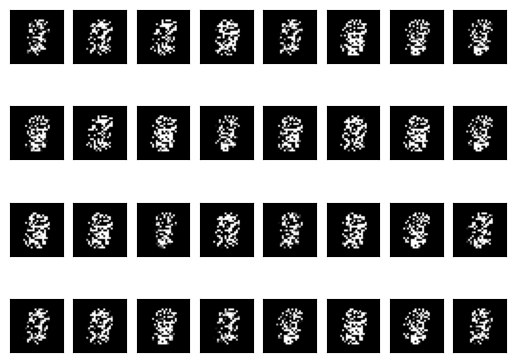

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

Z = random_noise = torch.randn((120,BATCH_SIZE, N_INP))
trans = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
view_data = [test_set[i][0] for i in range(4 * 8)]
plt.gray()

print("Images generated by GMMD")

for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)

    noise = torch.randn((1, N_INP)).to(device)
    y = gmmd_net(noise)
    plt.imshow(y.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

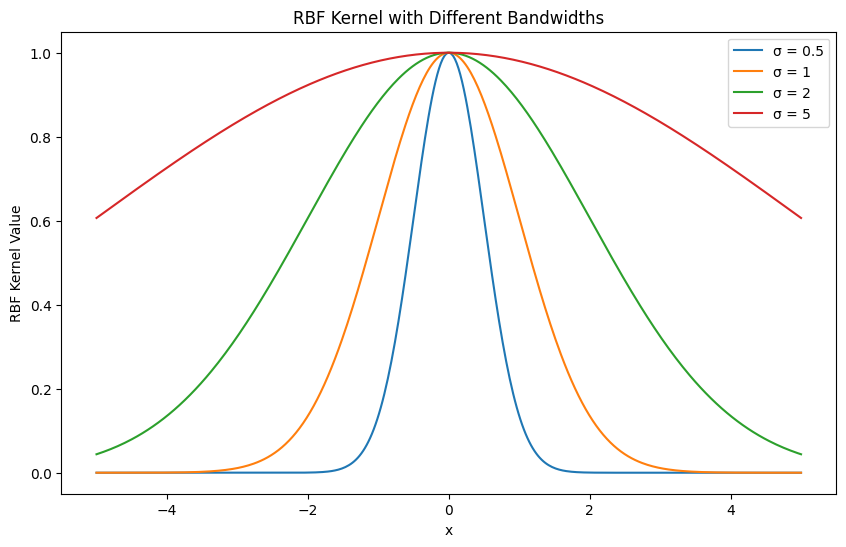

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

x = np.linspace(-5, 5, 400)
y = np.zeros_like(x)

sigmas = [0.5, 1, 2, 5]
plt.figure(figsize=(10, 6))

for sigma in sigmas:
    rbf_values = [rbf_kernel(np.array([xi]), np.array([0]), sigma) for xi in x]
    plt.plot(x, rbf_values, label=f'σ = {sigma}')

plt.title('RBF Kernel with Different Bandwidths')
plt.xlabel('x')
plt.ylabel('RBF Kernel Value')
plt.legend()
plt.show()